# Project: Vehicle Detection and Tracking

The objective of this project is to build a pipeline to properly identify objects within images (and by extension videos). In this case we are specifically identifying cars and non-cars. I will be using much of the lessons to build this pipeline. The code should be well commented and straight forward so as to explain itself as much as possible. I hope you follow along!

In [1]:
# Import necessary libraries used throughout the notebook
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Load training data

In [2]:
cars = []
noncars = []

# populate cars
basedir = "vehicles/"
image_types = os.listdir(basedir)
for imtype in image_types:
    cars.extend(glob.glob(basedir + imtype + '/*'))

# populate non-cars
basedir = "non-vehicles/"
image_types = os.listdir(basedir)
for imtype in image_types:
    noncars.extend(glob.glob(basedir + imtype + '/*'))
    
# write filenames for both into text files
with open('cars.txt', 'w') as f:
    for car in cars:
        f.write(car + '\n')
        
with open('non-cars.txt', 'w') as f:
    for noncar in noncars:
        f.write(noncar + '\n')
        
print('Number of cars:', len(cars))
print('Number of non-cars:', len(noncars))

Number of cars: 8792
Number of non-cars: 8968


### Functions grabbed from the lessons

In [3]:
# Define a function that takes an image and a new image size and returns a feature vector
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [4]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins)
    ghist = np.histogram(img[:,:,1], bins=nbins)
    bhist = np.histogram(img[:,:,2], bins=nbins)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features, rhist, ghist, bhist, bin_centers

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
def color_transform(img, color_space):
    if color_space != 'RGB':
        if color_space == 'HSV':
            output_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            output_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            output_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            output_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            output_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'RGB2YCrCb':
            output_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'BGR2YCrCb':
            output_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        elif color_space == 'RGB2LUV':
            output_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    else: output_img = np.copy(img)   
    return output_img

In [7]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = color_transform(img, color_space)
       
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features, _, _, _, _ = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)           
        else:
            if vis==True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    
    #9) Return concatenated array of features
    if vis==True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

In [8]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        image = mpimg.imread(file)
        file_features = single_img_features(image, color_space, spatial_size, hist_bins, orient, pix_per_cell,
                                           cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
        
        features.append(file_features)
    # Return list of feature vectors
    return features

In [9]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [10]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [11]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

In [12]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

Now let's play around and see what a random car and non-car look like

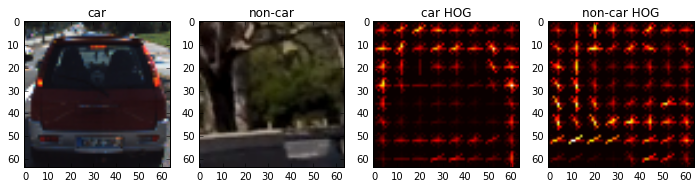

In [13]:
car_idx = np.random.randint(0, len(cars))
non_car_idx = np.random.randint(0, len(noncars))

random_car = mpimg.imread(cars[car_idx])
random_non_car = mpimg.imread(noncars[non_car_idx])

# params
color_space = 'RGB'
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16, 16) # down sample size
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

_, random_car_hog_image = single_img_features(random_car, color_space=color_space, spatial_size=spatial_size,
                                                 hist_bins=hist_bins, orient=orient,
                                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

_, random_non_car_hog_image = single_img_features(random_non_car, color_space=color_space, spatial_size=spatial_size,
                                                 hist_bins=hist_bins, orient=orient,
                                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

images = [random_car, random_non_car, random_car_hog_image, random_non_car_hog_image]
titles = ['car', 'non-car', 'car HOG', 'non-car HOG']
fig = plt.figure(figsize=(12,3))

visualize(fig, 1, 4, images, titles)

Let's play with more params for the same random car and non-car image, namely color spaces and pixels per cell

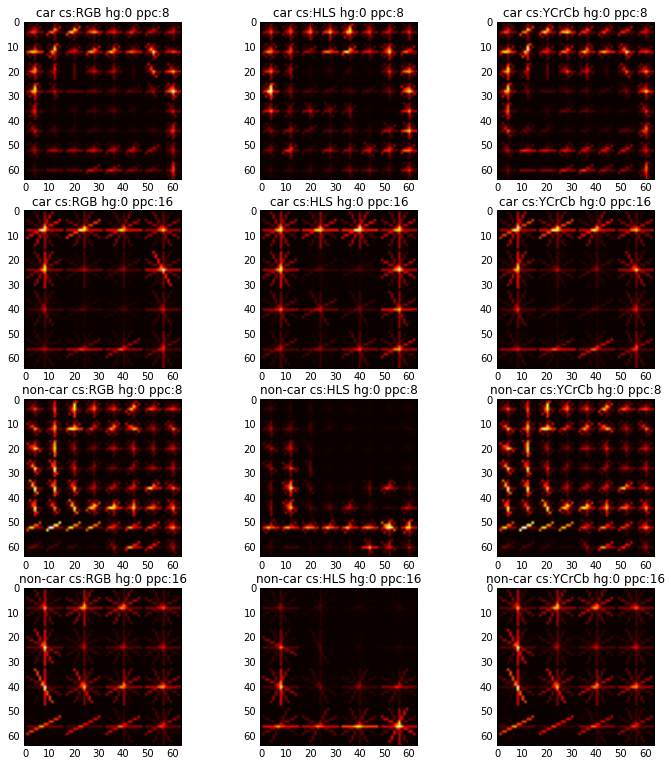

In [14]:
# params
color_spaces = ['RGB', 'HLS', 'YCrCb']
orient = 6
pix_per_cells = [8,16]
cell_per_block = 2
hog_channels = [0]
spatial_sizes = (16, 16) # down sample size
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_images = []
non_car_images = []
car_titles = []
non_car_titles = []

for pix_per_cell in pix_per_cells:
    for hog_channel in hog_channels:
        for color_space in color_spaces:
            _, random_car_hog_image = single_img_features(random_car, color_space=color_space, 
                                                          spatial_size=spatial_size, hist_bins=hist_bins, 
                                                          orient=orient, pix_per_cell=pix_per_cell, 
                                                          cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                          spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                                          hog_feat=hog_feat, vis=True)

            _, random_non_car_hog_image = single_img_features(random_non_car, color_space=color_space, 
                                                              spatial_size=spatial_size,hist_bins=hist_bins, 
                                                              orient=orient, pix_per_cell=pix_per_cell, 
                                                              cell_per_block=cell_per_block, 
                                                              hog_channel=hog_channel,spatial_feat=spatial_feat, 
                                                              hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
            
            car_images.append(random_car_hog_image)
            non_car_images.append(random_non_car_hog_image)
            title = 'cs:%s hg:%s ppc:%s' % (color_space, hog_channel, pix_per_cell)
            car_titles.append('car ' + title)
            non_car_titles.append('non-car ' + title)

fig = plt.figure(figsize=(12,40), dpi=300)
visualize(fig, 12, 3, car_images + non_car_images, car_titles + non_car_titles)

As you can see, the color space and pixels per cells make a big difference. Great. Now let's extend this for the entire set...

In [15]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, 'ALL'
spatial_size = (16, 16) # down sample size
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()

car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                                                 hist_bins=hist_bins, orient=orient,
                                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)


non_car_features = extract_features(noncars, color_space=color_space, spatial_size=spatial_size,
                                                 hist_bins=hist_bins, orient=orient,
                                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# how long did it take?
print(time.time()-t, "seconds to compute features")

# Create an array stack of feature vectors
X = np.vstack((car_features, non_car_features)).astype(np.float64)
# per-column scaler
X_scaler = StandardScaler().fit(X)
# apply scaler to X
scaled_X = X_scaler.transform(X)

# labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

# display useful information
print('Using:', orient, 'orientation,', pix_per_cell, 'pixels per cell,', cell_per_block, 'cells per block,',
     hist_bins, 'histogram bins,', spatial_size, 'spatial sampling')
print('Feature vector length', len(X_train[0]))

# using SVC
svc = LinearSVC()

# fit to SVC and track time
t = time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC')

# display accuracy
print('Test accuracy of SVC =', round(svc.score(X_test, y_test), 4))

165.53472113609314 seconds to compute features
Using: 9 orientation, 8 pixels per cell, 2 cells per block, 32 histogram bins, (16, 16) spatial sampling
Feature vector length 6156
87.14 Seconds to train SVC
Test accuracy of SVC = 0.9932


Very strong accuracy after playing with the parameters a little bit (different trials not displayed here for purpose of decluttering notebook). Now I'll create a function that takes in images (in the form of file paths) and a few parameters that I may tweak

In [16]:
# Process an image taking in an image, a y range, a window size,
# and the overlaps of the sliding window (expressed in decimal)
def process_image(img, y_start_stop=[None, None], xy_window=(128, 128), overlap=.5):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))

    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window=xy_window, xy_overlap=(overlap, overlap))
    
    t1 = time.time()

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    
    print(time.time()-t1, 'seconds to process a large image with', len(windows), 'windows')
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    return window_img

In [17]:
def process_and_visualize_images(images, y_start_stop=[None, None], xy_window=(128, 128), overlap=.5):
    output_images = []
    titles = []

    for filename in images:
        img = mpimg.imread(filename)
        window_img = process_image(img, y_start_stop, xy_window, overlap)
        output_images.append(window_img)
        titles.append('')

    fig = plt.figure(figsize=(12,18), dpi=300)
    visualize(fig, 5, 2, output_images, titles)

Let's look at how our detection looks for the first time!

0.0 1.0
1.6986761093139648 seconds to process a large image with 190 windows
0.0 1.0
1.579003095626831 seconds to process a large image with 190 windows
0.0 1.0
1.5385148525238037 seconds to process a large image with 190 windows
0.0 1.0
1.7680480480194092 seconds to process a large image with 190 windows
0.0 1.0
1.4990170001983643 seconds to process a large image with 190 windows
0.0 1.0
1.5651218891143799 seconds to process a large image with 190 windows


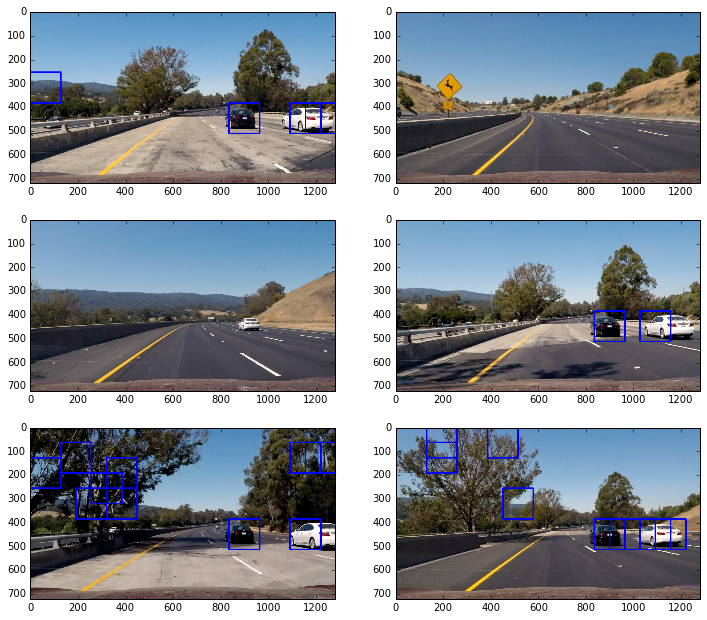

In [18]:
# attempt to draw windows on 6 test_images
searchpath = 'test_images/*'
test_images = glob.glob(searchpath)
process_and_visualize_images(test_images)

We're getting somewhere, minus the false positives! ... and a false negative. For the former let's eliminate the top half of the image in the sliding window search since we typically don't find cars in the sky or trees...

0.0 1.0
0.45815300941467285 seconds to process a large image with 57 windows
0.0 1.0
0.568364143371582 seconds to process a large image with 57 windows
0.0 1.0
0.49911999702453613 seconds to process a large image with 57 windows
0.0 1.0
0.4850020408630371 seconds to process a large image with 57 windows
0.0 1.0
0.48453497886657715 seconds to process a large image with 57 windows
0.0 1.0
0.47427892684936523 seconds to process a large image with 57 windows


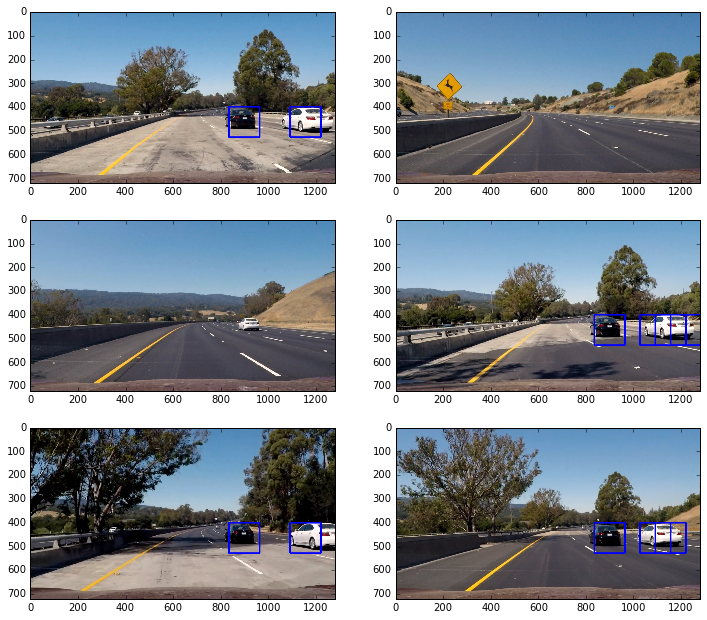

In [19]:
process_and_visualize_images(test_images, y_start_stop=[400,656])

We addressed some of the false positives but we still have a false negative i.e. in the third example. Our single window may be too large (or even too small for future car detection of closer/bigger cars). Further, we are not processing images very quickly. If you recall our implementation, we are doing HOG calculation for each window. Optimizing this will be our next focus. Later we will try different window sizes (57 windows isn't much) to reduce the false negatives.

But first we will introduce a function that will take labels, generated by this very handy function in scipy that combines processes heatmaps and returns to us labels of larger regions where the heatmap is hot. 

In [20]:
from scipy.ndimage.measurements import label

def get_labels(heatmap):
    return label(heatmap)

In [21]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [22]:
# a function that adds "heat" to a map for a list of bounding boxes
def generate_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

The following function will be the main function to return heatmap, which in turn will allow us to draw boxes. This function is different from our previous process_image function in the following ways:

1) It uses a trick for searching different window sizes. Rather than taking a window (i.e. 128 x 128) and downsizing it, it scales the entire image, applies HOG to said image, then subsamples the array. The net effect will be to sample in different window sizes

2) It creates a heatmap, which can be displayed, and is used for creating labels / drawing images.

In [23]:
def find_cars(img, y_start_stops, x_start_stops, scales, cells_per_steps=[2], pix_per_cell=8, orient=9, logging=False):
    img_boxes = []
    heatmap = np.zeros_like(img[:,:,0])
    
    # normalize
    img = img.astype(np.float32)/255
    
    window_count = 0
    t = time.time()
    
    for y_start_stop, x_start_stop, scale, cells_per_step in zip(y_start_stops, x_start_stops, scales, cells_per_steps):
    
        # crop to boundaries passed in
        cropped_img = img[y_start_stop[0]:y_start_stop[1],x_start_stop[0]:x_start_stop[1],:]
        # convert to new color
        cropped_img = color_transform(cropped_img, color_space='RGB2YCrCb')
        
        if scale != 1:
            imshape = cropped_img.shape
            resized_img = cv2.resize(cropped_img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        else:
            resized_img = cropped_img

        ch1 = resized_img[:,:,0]
        ch2 = resized_img[:,:,1]
        ch3 = resized_img[:,:,2]

        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        nxblocks = (ch1.shape[1] // pix_per_cell) - 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - 1
        nfeat_per_block = orient*cell_per_block**2

        window=64
        nblocks_per_window = (window // pix_per_cell) - 1

        # cells_per_step defines overlap. 1 - cells_per_step / pix_per_cell gives us overlap percentage
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        for xb in range(nxsteps):
            for yb in range(nysteps):
                window_count += 1
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                # extract HOG for patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # extract the image patch for spatial and hist
                subimg = cv2.resize(resized_img[ytop:ytop+window, xleft:xleft+window], (64,64))

                # use spatial and color hist features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features, _, _, _, _ = color_hist(subimg, nbins=hist_bins)

                # stack all 3 features
                feature_stack = np.hstack((spatial_features, hist_features, hog_features))
                
                test_features = X_scaler.transform(feature_stack.reshape(1, -1))
                
                # prediction with SVM
                pred = svc.predict(test_features)

                if pred == 1:
                    xbox_left = np.int(xleft*scale) + x_start_stop[0]
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)

                    top_left = (xbox_left, ytop_draw+y_start_stop[0])
                    bottom_right = (xbox_left+win_draw, ytop_draw+win_draw+y_start_stop[0])

                    img_boxes.append((top_left, bottom_right))

    generate_heat(heatmap, img_boxes)
    
    if logging:
        print(time.time()-t, 'seconds to run windows = ', window_count)
        
    return heatmap
        

In [24]:
def visualize_find_cars(example_images_path, y_start_stops, x_start_stops, scales, cells_per_steps):
    out_images = []
    out_titles = []

    for img_src in glob.glob(example_images_path):
        img = mpimg.imread(img_src)

        heatmap = find_cars(img, y_start_stops, x_start_stops, scales, cells_per_steps)
        
        labels = get_labels(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        
        out_images.append(img)
        out_images.append(heatmap)
        out_images.append(draw_img)

        out_titles.append("Original " + img_src[-9:])
        out_titles.append("With Heatmap")
        out_titles.append("With boxes")
    return out_images, out_titles

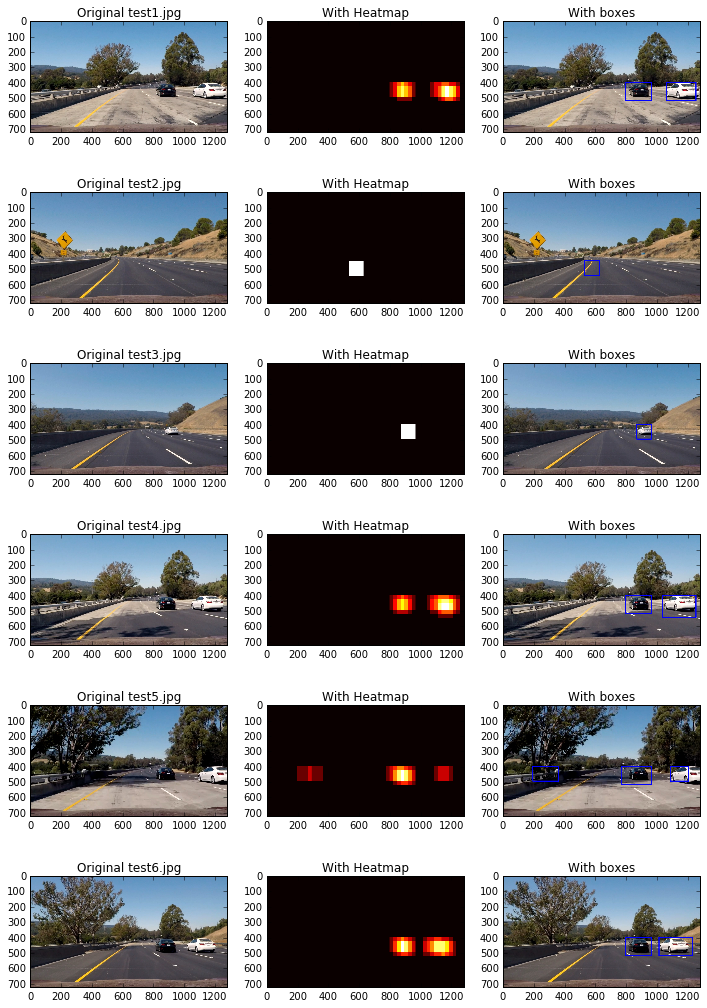

In [25]:
# params
y_start_stops = [(400,656)]
x_start_stops = [(0, 1280)]
scales = [1.5]
cells_per_steps = [2]

images_path = 'test_images/*'
out_images, out_titles = visualize_find_cars(example_images_path=images_path, y_start_stops=y_start_stops,
                                             x_start_stops=x_start_stops, scales=scales, cells_per_steps=cells_per_steps)
        
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 3, out_images, out_titles)

As you can see we have a false positive in test2.jpg and test6.jpg. Let's apply thresholding to help with that, and create a function that will ultimately used in producing a video. We will also try a few different scales, hence sliding window sizes, so that we detect cars of different sizes.

In [26]:
# Apply threshold to help remove false positives
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [27]:
def process_single_image(img, logging=False):
    # parameters
    y_start_stops = [(400,475),(400,500),(400,500),(400, 650),(400,650)]
    x_start_stops = [(325, 950),(0,550),(700, 1280),(950, 1280),(0, 350)]
    scales = [.75, 1.25, 1.25, 2, 2]
    cells_per_steps = [2, 1, 1, 1, 1]
    
    heatmap = find_cars(img, y_start_stops, x_start_stops, scales, cells_per_steps, logging=logging)

    # threshold to minimize false positives
    apply_threshold(heatmap, threshold=3)
    
    # handy function as mentioned to generate labels from contiguous regions in heatmap
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

1.1005611419677734 seconds to run windows =  465
1.0564250946044922 seconds to run windows =  465
1.1652989387512207 seconds to run windows =  465
1.0079381465911865 seconds to run windows =  465
0.9767189025878906 seconds to run windows =  465
1.0703260898590088 seconds to run windows =  465


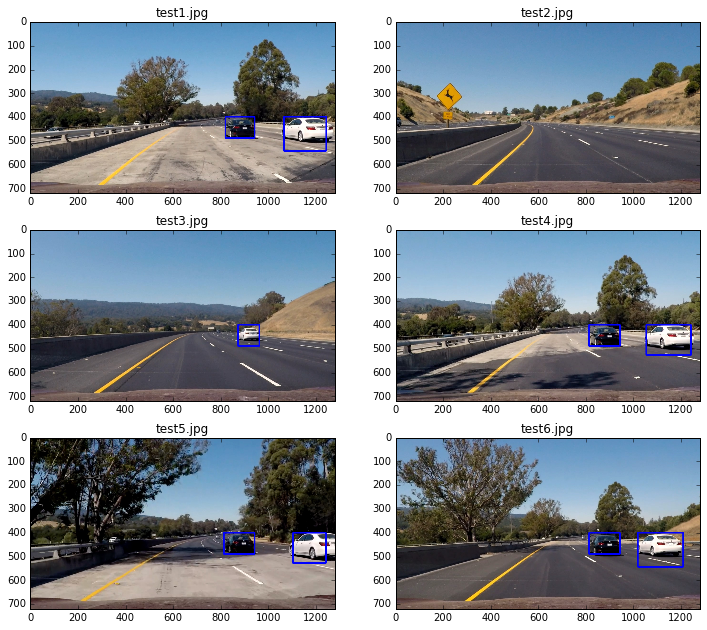

In [28]:
processed_imgs = []
titles = []

for img_src in glob.glob('test_images/*'):
        img = mpimg.imread(img_src)
        processed_img = process_single_image(img, logging=True)
        processed_imgs.append(processed_img)
        titles.append(img_src[-9:])
        
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, processed_imgs, titles)

We are ready to proceed with the video! But first, we don't want to process images independently. We need to integrate the heatmap over several frames so that we have better false positive rejection. Let's use a series of images and threshold the heatmap on that. I will explore the heatmaps when we process our first video.

In [29]:
last_n = 5
heatmaps = [None] * last_n
iteration = 0

from functools import reduce

def process_image_with_integration(img):
    global iteration, last_n, heatmaps
    
    # parameters
    y_start_stops = [(400,475),(400,500),(400,500),(400, 650),(400,650)]
    x_start_stops = [(325, 950),(0,550),(700, 1280),(950, 1280),(0, 350)]
    scales = [.75, 1.25, 1.25, 2, 2]
    cells_per_steps = [2, 1, 1, 1, 1]
    
    heatmap = find_cars(img, y_start_stops, x_start_stops, scales, cells_per_steps)
    
    heatmaps[iteration % last_n] = heatmap
    if iteration >= last_n:
        integrated_heatmap = reduce(lambda x, y: x+y, heatmaps)
    else:
        integrated_heatmap = heatmap

    # threshold to minimize false positives
    apply_threshold(integrated_heatmap, threshold=25)
    
    # handy function as mentioned to generate labels from contiguous regions in heatmap
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    iteration += 1
    
    return draw_img

### Video Processing

First we'll look at test_video after it's processed.

In [30]:
from moviepy.editor import VideoFileClip

In [31]:
last_n = 5
heatmaps = [None] * last_n
iteration = 0

output_v1 = 'test_video_processed.mp4'
clip1 = VideoFileClip("test_video.mp4")
test_clip = clip1.fl_image(process_image_with_integration)

%time test_clip.write_videofile(output_v1, audio=False, verbose=False)

 97%|█████████▋| 38/39 [00:43<00:01,  1.05s/it]


CPU times: user 37.1 s, sys: 1.72 s, total: 38.8 s
Wall time: 46.5 s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_v1))

Let's visualize the last five heatmaps produced from our new function process_image_with_integration

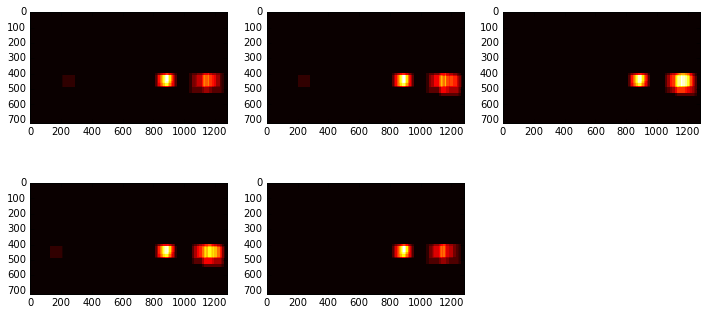

In [33]:
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 3, heatmaps, ['']*len(heatmaps))

These heatmaps are combined into one then thresholded to produce the window in our output video. I suspect raising the treshold and number of heatmap frames to use can significantly reduce the false positives, though possibly at the expense of introducing false negatives (vehicles that go undetected).

Let's try it on project_video.mp4 to wrap things up.

In [34]:
last_n = 5
heatmaps = [None] * last_n
iteration = 0

output_v2 = 'project_video_processed.mp4'
clip2 = VideoFileClip("project_video.mp4")
project_video_clip = clip2.fl_image(process_image_with_integration)

%time project_video_clip.write_videofile(output_v2, audio=False, verbose=False)

100%|█████████▉| 1260/1261 [21:31<00:00,  1.00it/s]


CPU times: user 20min 8s, sys: 42.9 s, total: 20min 51s
Wall time: 21min 34s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_v2))